## import relavant libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-12-26 17:17:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-12-26 17:17:15 (15.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [4]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])

In [5]:
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [6]:
df_price = pd.DataFrame(df["Closing Price (USD)"]).rename( columns={"Closing Price (USD)":"Price"})

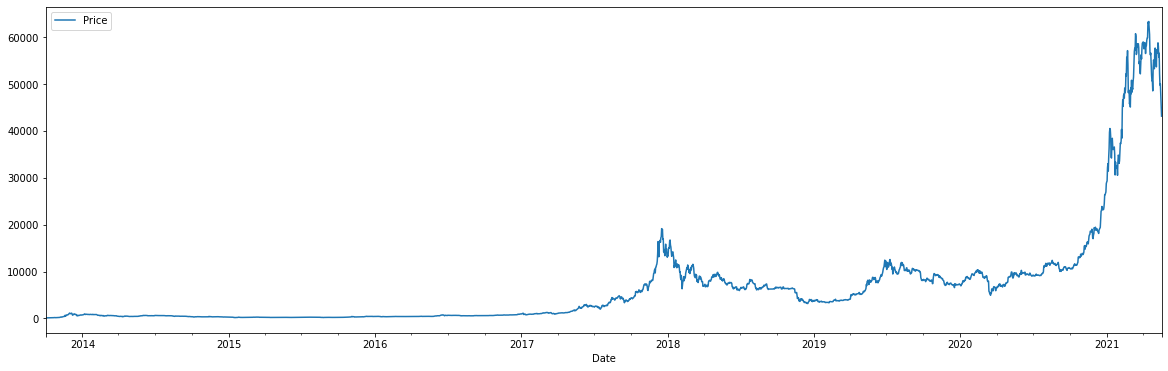

In [7]:
df_price.plot(figsize =(20,6))

import the data with csv

In [8]:
import csv 
import datetime
dates = []
price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_file = csv.reader(f, delimiter=",")
  next(csv_file) #to skip first line
  for line in csv_file:
    dates.append(datetime.datetime.strptime(line[1], "%Y-%m-%d"))
    price.append(float(line[2]))

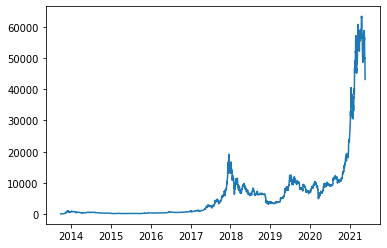

In [9]:
plt.plot(dates,price)

Formating the data and split it

In [10]:
time_steps = np.array(dates)
price = np.array(price)

In [11]:
split_size = int(len(time_steps)*0.8)

In [12]:
x_train, x_test, y_train , y_test = time_steps[:split_size], time_steps[split_size:], price[:split_size], price[split_size:]

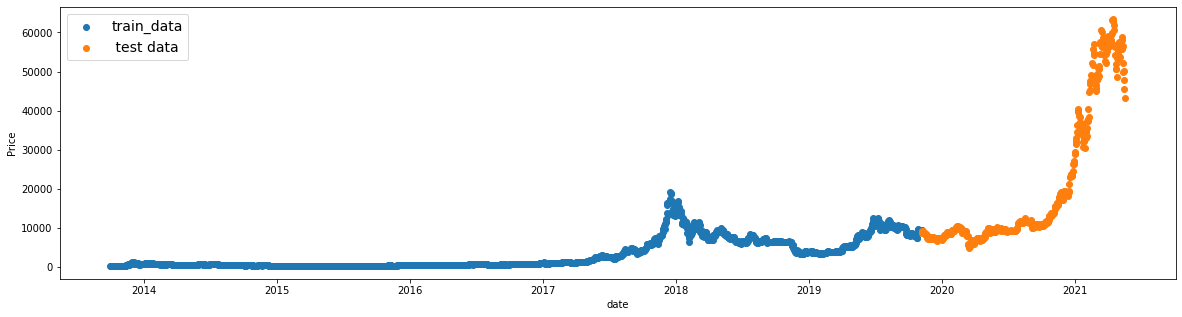

In [13]:
plt.figure(figsize = (20,5))
plt.scatter(x_train,y_train, label= "train_data")
plt.scatter(x_test,y_test, label =" test data")
plt.xlabel("date")
plt.ylabel("Price")
plt.legend(fontsize = 14)
plt.show()

In [14]:
def plot_time_series(x,y,label=None, start=0, end=None , format = "."):
  plt.plot( x[start:end],y[start:end],format, label= label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
   plt.legend(fontsize = 14)
  plt.grid(True)

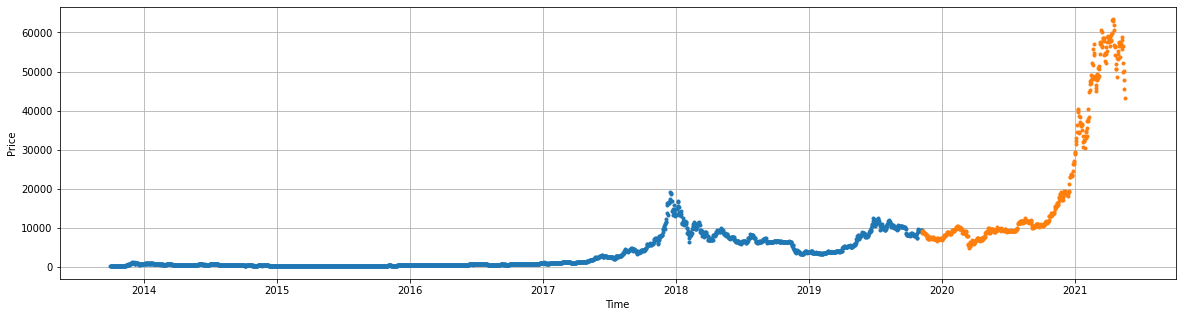

In [15]:
plt.figure(figsize = (20,5))
plot_time_series(x_train,y_train)
plot_time_series(x_test,y_test)

## Modeling 

### Model0: Naive model

$$\hat{y}_{t} = y_{t-1}$$ 

In [16]:
naive_forcast = y_test[:-1]

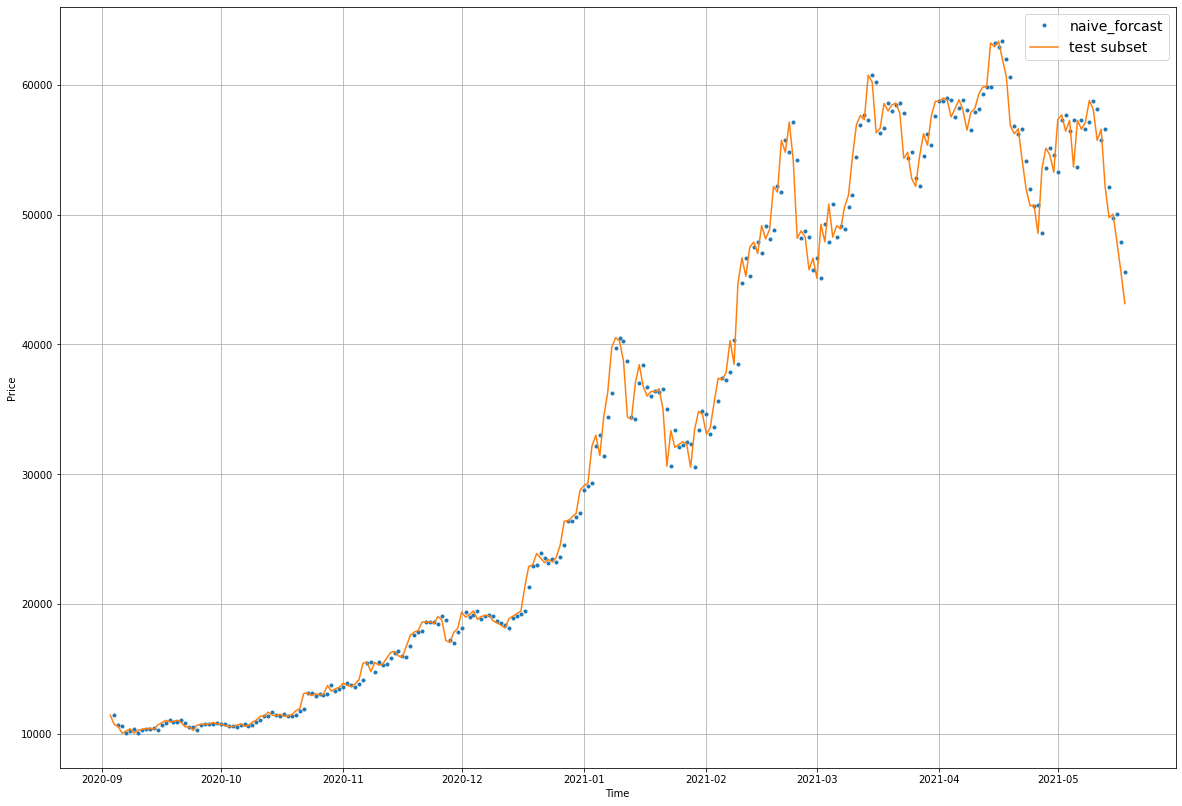

In [17]:
plt.figure(figsize=(20,14))
#plot_time_series(x_train, y_train)
plot_time_series(x_test[1:] , naive_forcast, label="naive_forcast", start = 300)
plot_time_series(x_test, y_test, format = "-", label = "test subset", start = 300)

MASE (mean absolute scaled error).	

In [18]:
import tensorflow as tf
def mean_absloute_scaled_error(y_pred, y_true):
 
  mean = tf.reduce_mean(tf.abs(y_pred-y_true))
  mean_naive  = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mean/mean_naive

In [19]:
mean_absloute_scaled_error(naive_forcast,y_test[1:])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

if the model better than naive should be lower than this 

In [20]:
def evaluate_preds(y_pred, y_true):

  y_pred = tf.cast(y_pred , dtype = tf.float32)
  y_true = tf.cast(y_true , dtype = tf.float32)
   
  mae = tf.keras.metrics.mean_absolute_error(y_true ,y_pred )
  mse = tf.keras.metrics.mean_squared_error(y_true ,y_pred )
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true ,y_pred )
  mase = mean_absloute_scaled_error(y_pred,y_true)

  return {
      "mae":mae.numpy(),
      "mse":mse.numpy(),
      "rmse":rmse.numpy(),
      "mape":mape.numpy(),
      "mase":mase.numpy()
  }

In [21]:
model0 = evaluate_preds(naive_forcast, y_test[1:])

the meaning of mae is that the bitcoin price is off 567 what the actual price is on avrage

## Formating data to windows and Horizons

In [22]:
def get_labeled_window(x,HORIZON=1 ):
  return  x[:,:- HORIZON], x[:,-HORIZON]

In [23]:
WINDOW_SIZE = 7
HORIZON = 1 
def get_full_windows_horizos(x,   WINDOW_SIZE = 7,   HORIZON = 1 ):

  window_step = np.expand_dims(np.arange(WINDOW_SIZE+HORIZON), axis=0)

  window_idexes = window_step + np.expand_dims(np.arange(len(x)-(WINDOW_SIZE+HORIZON-1)), axis=0).T

  windowed_array = x[window_idexes]
  print(windowed_array.shape)
  return get_labeled_window(windowed_array)




In [24]:
price.shape

(2787,)

In [25]:
windows , labels = get_full_windows_horizos(price)

(2780, 8)


In [26]:
windows.shape, labels.shape

((2780, 7), (2780,))

In [27]:
windows[-1], labels[-1], price[-1]

(array([55715.54665129, 56573.5554719 , 52147.82118698, 49764.1320816 ,
        50032.69313676, 47885.62525472, 45604.61575361]),
 43144.4712908603,
 43144.4712908603)

Well done !

### create a split and chekpoint callback

In [28]:
len(windows)

2780

In [29]:
def split(x,y):
   size = int(len(x)*0.8)
   return x[:size] , x[size:], y[:size], y[size:]

In [30]:
train_window , test_window , train_labels , test_labels = split(windows, labels)

In [31]:
test_window.shape, test_labels.shape

((556, 7), (556,))

In [32]:
from re import VERBOSE
import os
def checkpoint(model_name, file_path = "Expriments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(file_path,model_name) ,
                                            verbos = 0,
                                            save_best_only= True)

## Model 1 : Dense modedl 7 window and 1 horizon

In [33]:
from tensorflow.python import metrics
from tensorflow.keras import layers
model1 = tf.keras.Sequential([
    layers.Dense(128, "relu"),
    layers.Dense(HORIZON)
], name = "Model_1_Dense")

model1.compile(
    loss = "mse", 
    optimizer = "adam",
    metrics = ["mae", "mse"]
)



history = model1.fit(
      x=train_window,y=train_labels,
      epochs = 100,
      callbacks = [checkpoint("model1_dense")],
      batch_size = 128,
      validation_data = (test_window , test_labels)
)

Epoch 1/100
18/18 [==============================] - 2s 86ms/step - loss: 8302368.0000 - mae: 1632.1073 - mse: 8302368.0000 - val_loss: 2751803.5000 - val_mae: 1007.6095 - val_mse: 2751803.5000
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 525807.5625 - mae: 399.0140 - mse: 525807.5625 - val_loss: 9835815.0000 - val_mae: 2063.2158 - val_mse: 9835815.0000
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 191023.6562 - mae: 207.3531 - mse: 191023.6562 - val_loss: 4181897.7500 - val_mae: 1314.7603 - val_mse: 4181897.7500
Epoch 4/100
18/18 [==============================] - 1s 74ms/step - loss: 138287.7969 - mae: 172.0035 - mse: 138287.7969 - val_loss: 2160101.0000 - val_mae: 801.7883 - val_mse: 2160101.0000
Epoch 5/100
18/18 [==============================] - 1s 54ms/step - loss: 116646.7500 - mae: 145.5881 - mse: 116646.7500 - val_loss: 2107305.5000 - val_mae: 802.0279 - val_mse: 2107305.5000
Epoch 6/100
18/18 [===========================

In [34]:
model1 = tf.keras.models.load_model("/content/Expriments/model1_dense")

In [35]:
model1.evaluate(test_window , test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1234375.2500 - mae: 590.6635 - mse: 1234375.2500


[1234375.25, 590.6635131835938, 1234375.25]

In [36]:
preds = model1.predict(test_window)

18/18 [==============================] - 0s 2ms/step


In [37]:
y_test.shape, 

((558,),)

In [38]:
evaluation_list = []

In [39]:
model0

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Evaluting our model

In [40]:
model1.evaluate(test_window,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1234375.2500 - mae: 590.6635 - mse: 1234375.2500


[1234375.25, 590.6635131835938, 1234375.25]

In [41]:
preds = np.squeeze(model1.predict(test_window))

18/18 [==============================] - 0s 2ms/step


In [42]:
test_labels.shape,preds.shape

((556,), (556,))

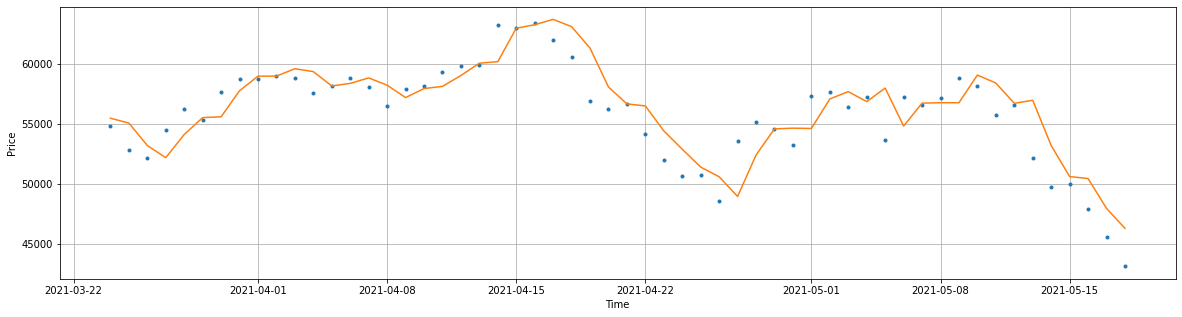

In [43]:
plt.figure(figsize=(20,5))
offset = 500
plot_time_series(x_test[- len(test_window):],test_labels , format= ".", start=offset)
plot_time_series(x_test[- len(test_window):],preds , format= "-",start=offset)



In [44]:
evaluate_preds(test_labels, preds)

{'mae': 590.6634,
 'mse': 1234375.1,
 'rmse': 1111.0244,
 'mape': 2.6288822,
 'mase': 1.2638927}

In [45]:
model0

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

# Model 2 : 30 window and 1 horizon

In [46]:
price.shape

(2787,)

In [47]:
windows , horizons =get_full_windows_horizos(price,WINDOW_SIZE=30)

(2757, 31)


In [48]:
windows.shape,horizons.shape

((2757, 30), (2757,))

In [49]:
train_windows , test_windows , train_labels , test_labels = split(windows, horizons)

In [50]:
train_windows.shape, test_labels.shape

((2205, 30), (552,))

In [51]:
model2 = tf.keras.Sequential([
    layers.Dense(128, "relu"),
    layers.Dense(HORIZON)
], name = "Model_1_Dense")

model2.compile(
    loss = "mse", 
    optimizer = "adam",
    metrics = ["mae", "mse"]
)



history2 = model2.fit(
      x=train_windows,y=train_labels,
      epochs = 100,
      callbacks = [checkpoint("model1_dense")],
      batch_size = 128,
      validation_data = (test_windows , test_labels)
)

Epoch 1/100
18/18 [==============================] - 2s 90ms/step - loss: 696592.5000 - mae: 432.0401 - mse: 696592.5000 - val_loss: 9219087.0000 - val_mae: 1739.9158 - val_mse: 9219087.0000
Epoch 2/100
18/18 [==============================] - 1s 48ms/step - loss: 284006.9062 - mae: 249.1172 - mse: 284006.9062 - val_loss: 5776924.5000 - val_mae: 1402.0155 - val_mse: 5776924.5000
Epoch 3/100
18/18 [==============================] - 1s 37ms/step - loss: 232223.1094 - mae: 218.4378 - mse: 232223.1094 - val_loss: 4616435.0000 - val_mae: 1170.1085 - val_mse: 4616435.0000
Epoch 4/100
18/18 [==============================] - 1s 67ms/step - loss: 204736.1875 - mae: 199.8018 - mse: 204736.1875 - val_loss: 4231015.0000 - val_mae: 1120.6152 - val_mse: 4231015.0000
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 229020.7656 - mae: 222.8236 - mse: 229020.7656 - val_loss: 5833843.0000 - val_mae: 1492.5631 - val_mse: 5833843.0000
Epoch 6/100
18/18 [===========================

In [59]:
model1.evaluate(test_windows , test_labels)

InvalidArgumentError: ignored

In [ ]:

plt.figure(figsize=(20,5))
offset = 500
plot_time_series(x_test[- len(test_windows):],test_labels , format= ".", start=offset)
plot_time_series(x_test[- len(test_windows):],preds , format= "-",start=offset)


In [1]:
evaluate_preds(y_true=test_labels, y_pred = preds)

NameError: ignored